In [1]:
HEIGHT, WIDTH, CHANNELS = 315, 315 , 3

In [2]:
DATA_DIR = "c:/Users/Homer/PycharmProjects/Images-WORK/data/"
IMAGES_DIR = DATA_DIR + "images/"

#IMAGES_DIR = "i:/Kaggle/PetFinder/data/train/"


BATCH_SIZE = 8

### Import necessaries

In [3]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

import shutil, pathlib
import os, math
from os.path import isfile, join

import seaborn as sns
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

print(tf.version.VERSION)

2.6.0


In [5]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

REPLICAS: 1
2.6.0
Num GPUs Available:  1


In [6]:
def set_display():
    """Function sets display options for charts and pd.DataFrames.
    """
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 14, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    #pd.set_option('display.max_columns', None)
    #pd.set_option('display.max_rows', None)
    #pd.options.display.float_format = '{:.4f}'.format
set_display()

In [7]:
def show_images(images_index, columns = 4, resize = True):
    
    rows = math.ceil(len(images_index)/columns)  
    
    #fig=plt.figure(figsize=(20, round(len(images_index)*16/9)))
    fig=plt.figure(figsize=(20, rows *5))    
      

    for i in range(len(images_index)):        
        
        fig.add_subplot(rows, columns, i+1)
        src = IMAGES_DIR + all_images[images_index[i]]
        img = cv2.imread(src)    
        
        if resize:
            img = cv2.resize(img, (HEIGHT, WIDTH))
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.axis('off')
        plt.imshow(img) 
        
        title = str(all_images[images_index[i]])
        
        for x in np.flip(np.argsort(image_embeddings[images_index[i]]))[:3]:
            
            title += "\n" + str([CLASSES_NAMES[x], round(image_embeddings[images_index[i]][x],3)  ])
            #title += "\n" + str(round(image_embeddings[images_index[i]][x],3)) + " : " + str(CLASSES_NAMES[x]) 
        plt.title(title)                 
    plt.tight_layout()
    plt.show()

In [8]:
# Datasets utility functions
def get_name(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    name = parts[-1]
    return name

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)    
    
    #image = center_crop(image)
    #image = crop_tf_image(image)
    # CROP BLACK BORDERS -----------------------------------------
    #image = tf.convert_to_tensor(hist_equal_rgb_AHQ(image.numpy()))
    
    
    #image = tf.py_function(func=crop_tf_image, inp=[image], Tout=tf.float32)
    
    # CROP BLACK BORDERS -----------------------------------------  
    
    image = tf.image.resize(image, [HEIGHT, WIDTH]) # Expected shape
    
    #image = tf.cast(image, tf.float32) / 255.0
    
    return image

def resize_image(image):
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def process_path(file_path):
    
    name = get_name(file_path)
    img = tf.io.read_file(file_path)
    img = decode_image(img)
    return img

def scope_image(image):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.clip_by_value(image, 0, 1)
    return image

def get_dataset(files_df, augment = False, ordered = False, repeated = False, cached = False):    
    #dataset = tf.data.Dataset.list_files(f'{files_path}*{extension}', shuffle=shuffled)
    
    #--------------------
    #dataset = tf.data.Dataset.from_tensor_slices((DATA_TRAIN_DIR + train["file_name"][train["fold"] == fold]))
    dataset = tf.data.Dataset.from_tensor_slices((files_df))
    
    #labels = tf.data.Dataset.from_tensor_slices((labels))
    
    #-----------------------
    
    dataset = dataset.map(process_path, num_parallel_calls=AUTO)
    
    if augment:
        
        dataset = dataset.map(transform_mat, num_parallel_calls=AUTO)
        dataset = dataset.map(data_augment,  num_parallel_calls=AUTO)       
        
        
        
    dataset = dataset.map(resize_image, num_parallel_calls=AUTO)  
    
    #dataset = dataset.map(scope_image, num_parallel_calls=AUTO)
    
    
    if not ordered:
        dataset = dataset.shuffle(2048)
        
    if repeated:
        dataset = dataset.repeat()
    
    
    
    dataset = dataset.batch(BATCH_SIZE)
    
    if cached:
        dataset = dataset.cache()
    
    dataset = dataset.prefetch(AUTO)
    return dataset

In [9]:
def get_model():    
    
    inp = tf.keras.layers.Input(shape = [HEIGHT, WIDTH, CHANNELS])
    out = keras.applications.EfficientNetB0(weights = "imagenet", include_top = False, pooling = "avg")(inp)    
    #out = keras.applications.EfficientNetB0(weights = "imagenet")(inp)    
    model = tf.keras.models.Model(inputs = [inp], outputs = [out]) 
    
    return model

In [10]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 315, 315, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
Total params: 4,049,571
Trainable params: 4,007,548
Non-trainable params: 42,023
_________________________________________________________________


In [11]:
CLASSES_NAMES = eval(open(DATA_DIR + "imagenet1000_clsidx_to_labels.txt").read())

In [12]:
all_images = [f for f in os.listdir(IMAGES_DIR) if isfile(join(IMAGES_DIR, f))]
print(all_images[:10])
print("ALL_FILES =", len(all_images))

['cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.1001.jpg', 'cat.1002.jpg', 'cat.1003.jpg', 'cat.1004.jpg', 'cat.1005.jpg', 'cat.1006.jpg']
ALL_FILES = 8005


In [13]:
dataset = get_dataset(IMAGES_DIR + pd.Series(all_images), augment = False, ordered=True, repeated=False, cached=False)
image_embeddings = model.predict(dataset, verbose = 1)
print('image embeddings shape', image_embeddings.shape)

1001/1001 [==============================] - 28s 25ms/step
image embeddings shape (8005, 1280)


In [14]:
#show_images([50, 1, 85, 65,  4500, 5020, 6001, 7000])

In [15]:
# preddf = pd.DataFrame(image_embeddings)
# preddf

In [16]:
all_types = [x[:3] for x in all_images]
all_types_digits = [0 if x == 'dog' else 1 for x in all_types]
all_types[:5]

['cat', 'cat', 'cat', 'cat', 'cat']

In [17]:
sum(all_types_digits), len(all_types_digits)

(4000, 8005)

In [18]:
res = {}

In [19]:
# from sklearn.cluster import KMeans
# wcss = []
# for i in range(1, 11):
#     #kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#     kmeans = KMeans(n_clusters=i, random_state=0)
#     kmeans.fit(image_embeddings)
#     wcss.append(kmeans.inertia_)
# plt.plot(range(1, 11), wcss)
# plt.title('Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()

# StandardScaler

In [20]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(preddf)
# scaled_features.shape

In [21]:
#scaled_features = preddf

In [22]:
# from sklearn.cluster import KMeans
# wcss = []
# for i in range(1, 11):
#     #kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#     kmeans = KMeans(n_clusters=i, random_state=0)
#     kmeans.fit(scaled_features)
#     wcss.append(kmeans.inertia_)
# plt.plot(range(1, 11), wcss)
# plt.title('Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()

In [23]:
#scaled_features.shape

In [24]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(image_embeddings)


res["KMeans"] = accuracy_score(kmeans.labels_, all_types_digits)
res["KMeans"]

0.010243597751405372

# PCA

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embed_pca = pca.fit_transform(image_embeddings)
#principalComponents = pca.fit_transform(image_embeddings)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])
# principalDf = pd.concat([principalDf, pd.Series(all_types, name="type")], axis = 1)

[Text(0.5, 1.0, 'PCA')]

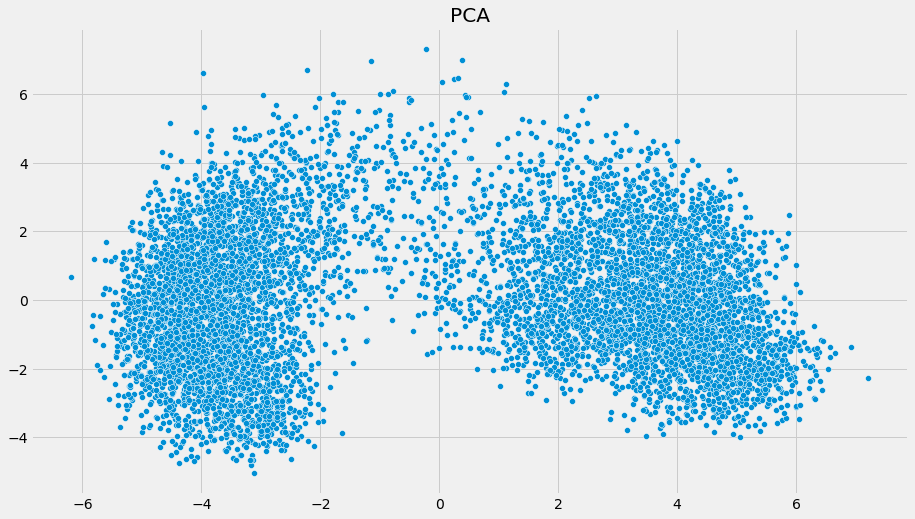

In [26]:
#sns.scatterplot(x=principalDf['principal component 1'], y=principalDf['principal component 2'], hue=all_types)
sns.scatterplot(x=embed_pca[:,0], y=embed_pca[:,1]).set(title='PCA')

In [27]:
# from sklearn.cluster import KMeans
# wcss = []
# for i in range(1, 11):
#     #kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#     kmeans = KMeans(n_clusters=i, random_state=0)
#     kmeans.fit(embed_pca)
#     wcss.append(kmeans.inertia_)
# plt.plot(range(1, 11), wcss)
# plt.title('Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()

[Text(0.5, 1.0, 'PCA with KMeans')]

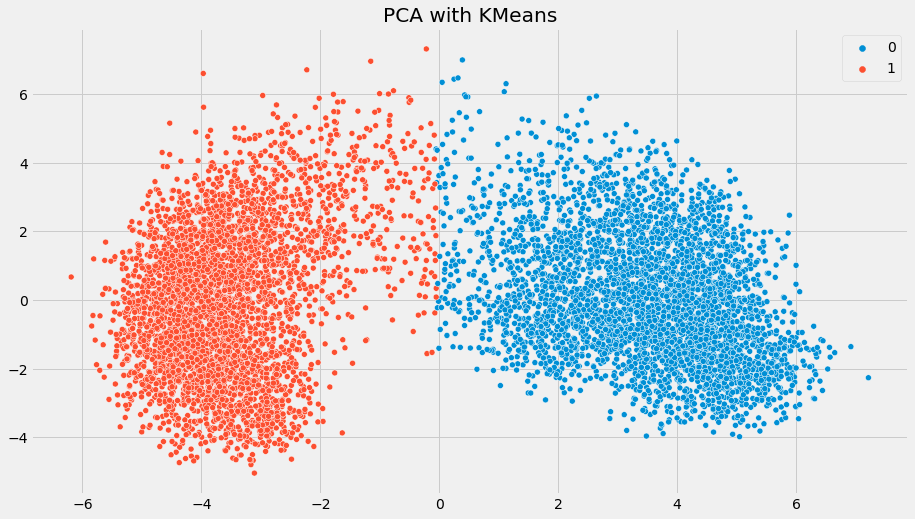

In [28]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(embed_pca)
sns.scatterplot(x=embed_pca[:,0], y=embed_pca[:,1], hue = kmeans.labels_).set(title='PCA with KMeans')

[Text(0.5, 1.0, 'PCA')]

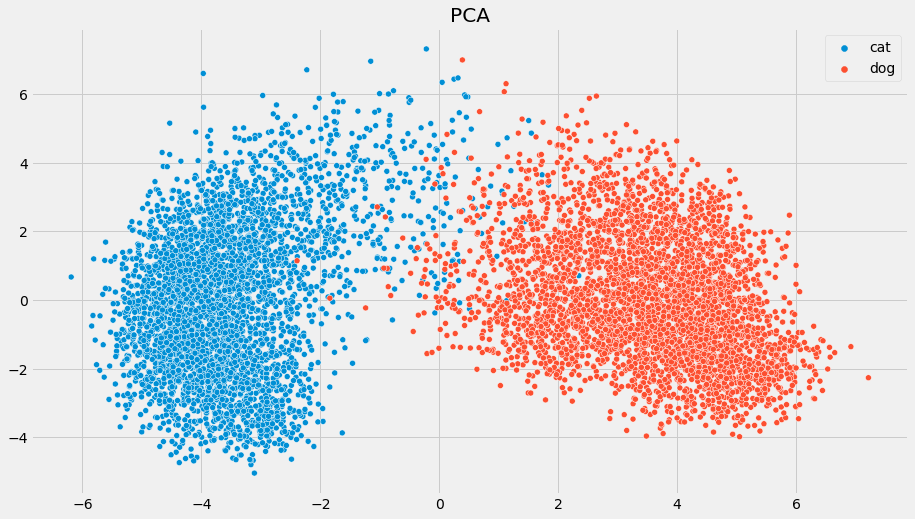

In [29]:
sns.scatterplot(x=embed_pca[:,0], y=embed_pca[:,1], hue = all_types).set(title='PCA')

In [30]:
res["PCA"] = accuracy_score(kmeans.labels_, all_types_digits)
res["PCA"]

0.9872579637726421

# UMAP

In [31]:
import umap

In [32]:
embed_umap =   umap.UMAP().fit_transform(image_embeddings)

[Text(0.5, 1.0, 'UMAP')]

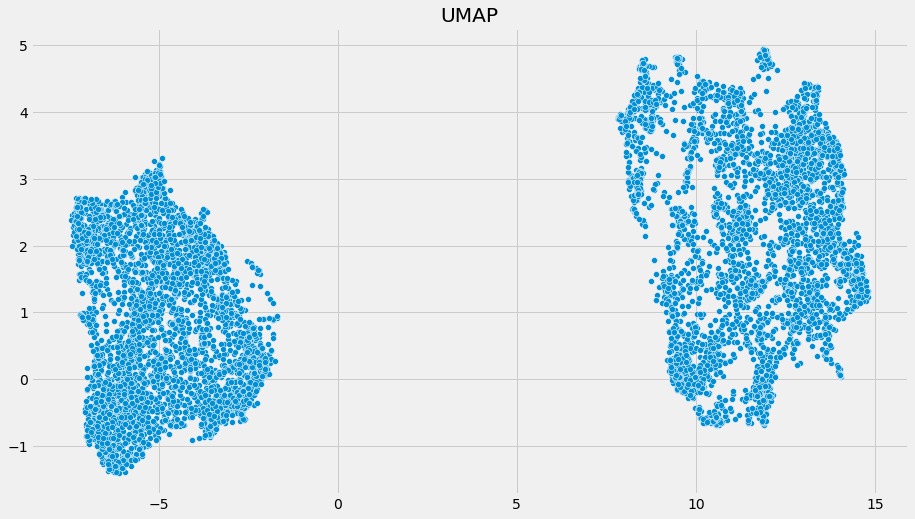

In [33]:
sns.scatterplot(x=embed_umap[:,0], y=embed_umap[:,1]).set(title='UMAP')

[Text(0.5, 1.0, 'UMAP')]

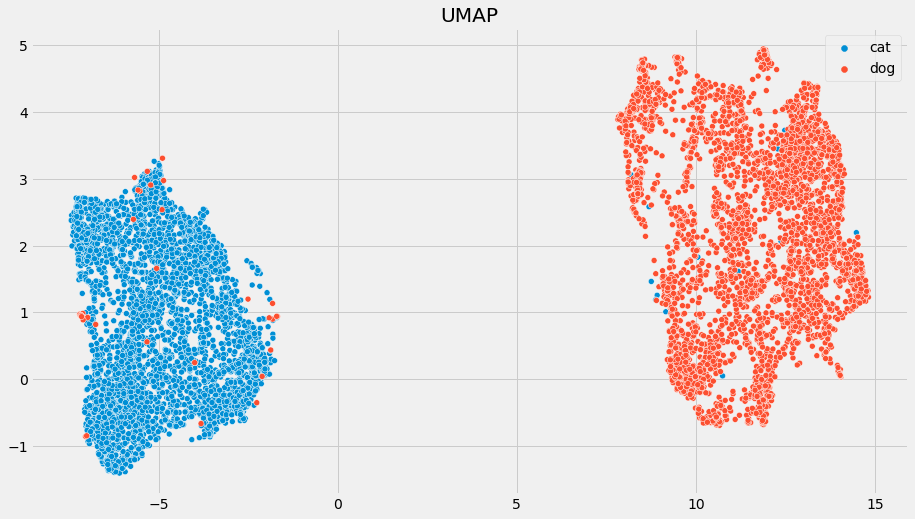

In [34]:
sns.scatterplot(x=embed_umap[:,0], y=embed_umap[:,1], hue=all_types).set(title='UMAP')

[Text(0.5, 1.0, 'UMAP with KMean')]

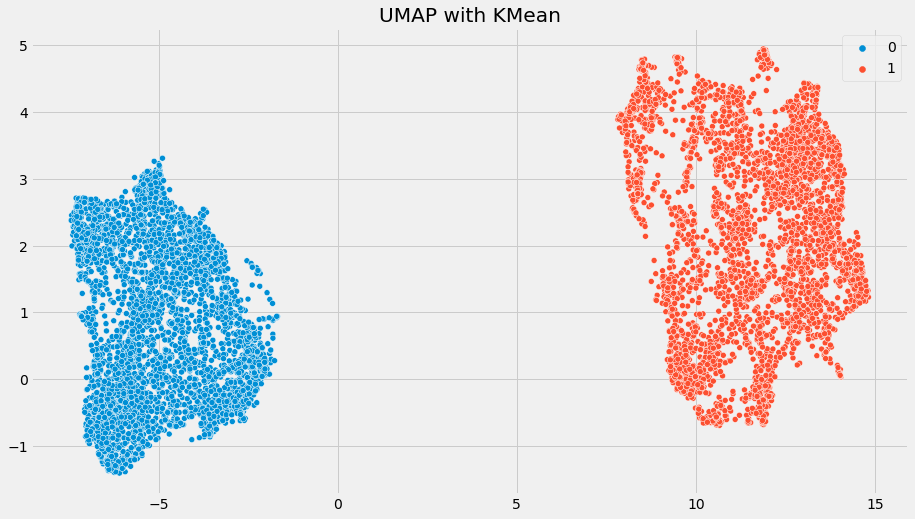

In [35]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(embed_umap)
sns.scatterplot(x=embed_umap[:,0], y=embed_umap[:,1], hue = kmeans.labels_).set(title='UMAP with KMean')

In [36]:
res["UMAP"] = accuracy_score(kmeans.labels_, all_types_digits)
res["UMAP"]

0.006246096189881324

# T-SNE

In [37]:
from sklearn.manifold import TSNE

In [38]:
tsne = TSNE(n_components=2, verbose=1, random_state=0)
embed_tsne = tsne.fit_transform(image_embeddings)
#embed_2d = tsne.fit_transform(image_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8005 samples in 0.009s...
[t-SNE] Computed neighbors for 8005 samples in 1.575s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8005
[t-SNE] Computed conditional probabilities for sample 2000 / 8005
[t-SNE] Computed conditional probabilities for sample 3000 / 8005
[t-SNE] Computed conditional probabilities for sample 4000 / 8005
[t-SNE] Computed conditional probabilities for sample 5000 / 8005
[t-SNE] Computed conditional probabilities for sample 6000 / 8005
[t-SNE] Computed conditional probabilities for sample 7000 / 8005
[t-SNE] Computed conditional probabilities for sample 8000 / 8005
[t-SNE] Computed conditional probabilities for sample 8005 / 8005
[t-SNE] Mean sigma: 2.372583
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.546722
[t-SNE] KL divergence after 1000 iterations: 2.208928


[Text(0.5, 1.0, 'T-SNE')]

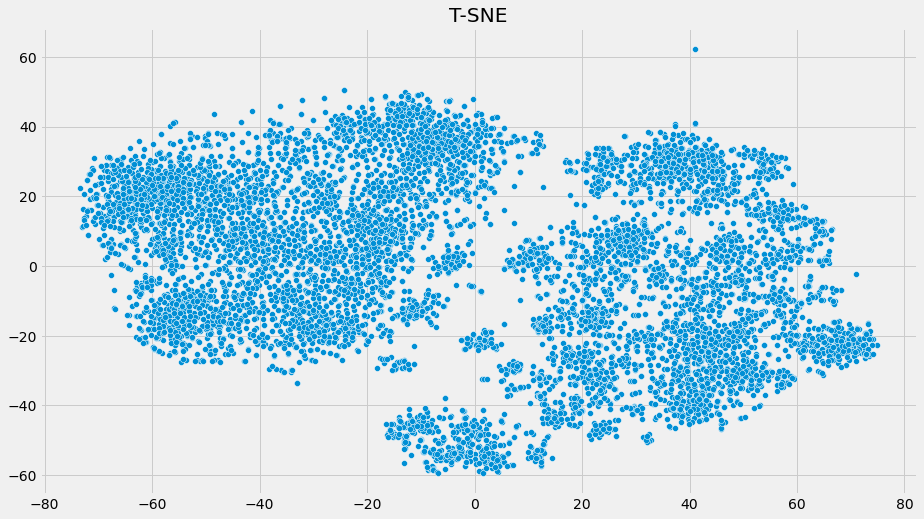

In [39]:
sns.scatterplot(x=embed_tsne[:,0], y=embed_tsne[:,1]).set(title='T-SNE')

[Text(0.5, 1.0, 'T-SNE with KMeans')]

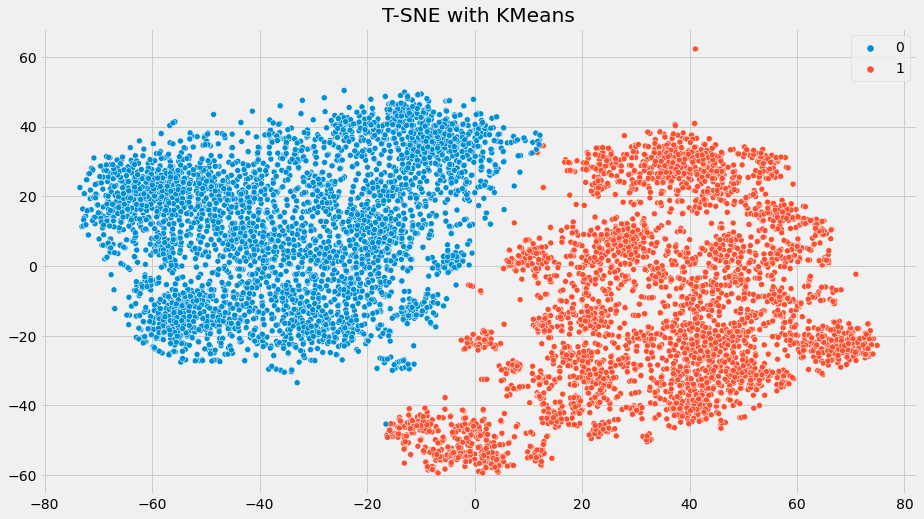

In [40]:
kmeans = KMeans(n_clusters = 2, random_state = 0)
kmeans.fit(embed_tsne)
sns.scatterplot(x = embed_tsne[:,0], y = embed_tsne[:,1], hue = kmeans.labels_).set(title='T-SNE with KMeans')

[Text(0.5, 1.0, 'T-SNE')]

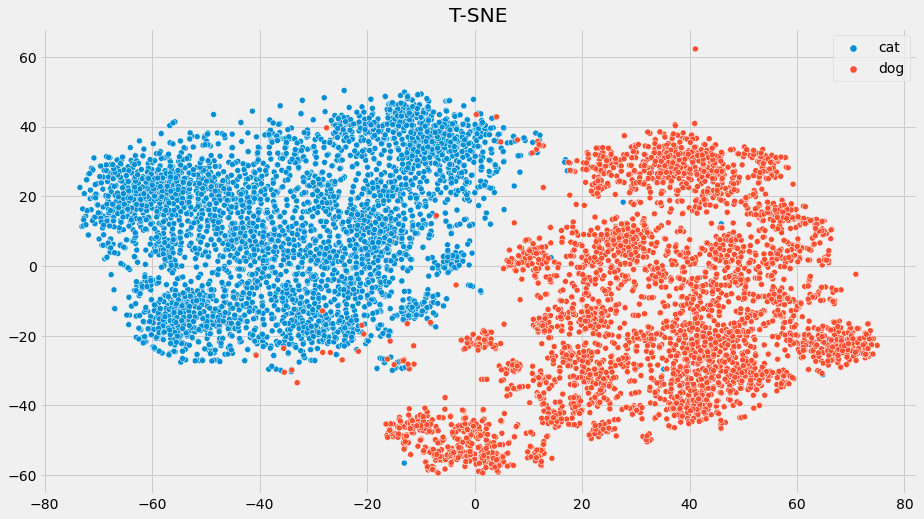

In [41]:
sns.scatterplot(x = embed_tsne[:,0], y = embed_tsne[:,1], hue = all_types).set(title='T-SNE')

In [42]:
res["T-SNE"] = accuracy_score(kmeans.labels_, all_types_digits)
res["T-SNE"]

0.007995003123048095

In [43]:
#res["MEAN"] = round((sum(res.values()) / len(res)),4)

In [44]:
for r in res:
    res[r] = round(res[r], 4)
    if res[r] < 0.3: res[r] = 1 - res[r]

In [45]:
res

{'KMeans': 0.9898, 'PCA': 0.9873, 'UMAP': 0.9938, 'T-SNE': 0.992}

In [46]:
list(res.values())

[0.9898, 0.9873, 0.9938, 0.992]

In [47]:
# BEGIN LOG FILE
f = open('log.txt','a')
#f.write('#############################\n')
#f.write(f'Trial HEIGHT={HEIGHT}, WIDTH={WIDTH}\n')
f.write(str(HEIGHT)+","+ str(WIDTH)+","+str(list(res.values())))
f.write('\n')
f.close()